# Skin Lesion Classification
The project focuses on developing a deep learning model to classify skin lesion diseases based on image inputs. Utilizing deep learning technique, the model is trained on a diverse dataset of skin lesion images, each labeled with its corresponding disease category. The goal is to accurately identify and differentiate between multiple types of skin conditions, including benign and malignant lesions. Through meticulous preprocessing, augmentation, and fine-tuning of the neural network, the project aims to achieve high classification accuracy, providing a valuable tool for early detection and diagnosis of skin diseases. This automated classification system has the potential to assist dermatologists in clinical settings, enhance diagnostic efficiency, and ultimately contribute to improved patient outcomes.

In [1]:
# For the case of using Google Colab, mount Google Drive to the Colab environment
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
cd /content/drive/MyDrive/UCCD3074_Labs/Assignment2

/content/drive/MyDrive/UCCD3074_Labs/Assignment2


## Import Libraries

In [63]:
!pip install torchinfo

import pandas as pd
import numpy as np
import torch
import os
import shutil
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import seaborn as sns

from torchvision.models import ResNet50_Weights
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import Dataset, WeightedRandomSampler, DataLoader, Subset
from transformers import ConvNextForImageClassification
from torchvision.transforms.functional import to_pil_image
from torchvision import transforms
from torchinfo import summary
from PIL import Image

## Data Preparation

In [10]:
# Combine images in different folders into one folder
def combine_folders(src1, src2, dest):

    copied_files = []  # List to store names of successfully copied files

    # Create folder when destination folder not exist, exit function if destination folder contains contents from the source folder
    if not os.path.exists(dest):
      print(f"Destination folder {dest} created...")
      os.makedirs(dest)

    else:
      # Recreate folder when destination folder do not have all the contents in source folders to avoid overlapping contents
      if len(os.listdir(dest)) == (len(os.listdir(src1)) + len(os.listdir(src2))):
        print("Content in source 1 folder and source 2 folder have been copied to destination folder")

        for filename in os.listdir(dest):
            copied_files.append(filename)

        return copied_files

      else:
        shutil.rmtree(dest)
        os.makedirs(dest)


    print(f"Copying images in {src1} into {dest}...")

    # Loop through all content in source folder 1 and copy into destination folder, if source 1 folder exist
    if os.path.exists(src1):
      print('Source 1 folder consist of ', len(os.listdir(src1)), " elements")

      for images in os.listdir(src1):

        # Define the source path and the destination path for each images
        src_path = os.path.join(src1, images)
        dest_path = os.path.join(dest, images)

        # Copy to the destination folder
        shutil.copy(src_path, dest_path)
        copied_files.append(images)

      print(f"All images in {src1} have been copied into {dest}...")

    else:
      print(f"{src1} not found")


    print(f"Copying images in {src2} into {dest}...")

    # loop through all content in source folder 2 and copy into destination folder, if source 2 folder exist
    if os.path.exists(src2):
      print('Source 2 folder consist of ', len(os.listdir(src2)), " elements")

      for images in os.listdir(src2):

        # Define the source path and the destination path for each images
        src_path = os.path.join(src2, images)
        dest_path = os.path.join(dest, images)

        # Copy to the destination folder
        shutil.copy(src_path, dest_path)
        copied_files.append(images)

      print(f"All images in {src2} have been copied into {dest}...")

    else:
      print(f"{src2} not found")

    print('Destination folder consist of ', len(os.listdir(dest)), " elements")

    return copied_files

In [11]:
# Define source paths to combined and destination path to store
src1 = "Dataset/HAM10000_images_part_1/"
src2 = "Dataset/HAM10000_images_part_2/"
dest = "Dataset/HAM10000/"
copied_files = combine_folders(src1, src2, dest)

Content in source 1 folder and source 2 folder have been copied to destination folder


#Exploratory Data Analysis
Exploratory Data Analysis (EDA) is a crucial step in the **data analysis** process where we aim to understand the dataset, summarize its **main characteristics, identify patterns and relationships, detect anomalies and outliers, and visualize data**. By using statistical methods and visualization tools, we can gain insights into the **structure, size, and type of data, detect correlations among variables, and identify unusual data points** that may require further investigation. EDA helps in **formulating hypotheses, guiding further analysis, and informing decision-making** by providing a clear understanding of the data's underlying structure and characteristics.

In [45]:
# Load the metadata CSV file for the HAM10000 dataset into a DataFrame
train_file = "Dataset/HAM10000_metadata.csv"
skin_train_df = pd.read_csv(train_file)

# Add a new column to the DataFrame that includes the image file extension
skin_train_df['image_id_with_extension'] = skin_train_df['image_id'] + '.jpg'

# Filter the DataFrame to include only the rows where the image files are in the copied files list
skin_train_df = skin_train_df[skin_train_df['image_id_with_extension'].isin(copied_files)]
skin_train_df = skin_train_df.drop(columns=['image_id_with_extension'])

skin_train_df.head(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back


In [46]:
# Check for null values in each attribute
print("Null counts for each attribute:")
print(skin_train_df.isnull().sum())
print()

print("Counts of 'unknown' for each attribute:")
print((skin_train_df == 'unknown').sum())

# Drop rows with null or 'unknown' values for EDA purpose
skin_df = skin_train_df.dropna()
skin_df = skin_df[(skin_train_df != 'unknown').all(axis=1)]

Null counts for each attribute:
lesion_id        0
image_id         0
dx               0
dx_type          0
age             55
sex              0
localization     0
dtype: int64

Counts of 'unknown' for each attribute:
lesion_id         0
image_id          0
dx                0
dx_type           0
age               0
sex              57
localization    205
dtype: int64


<ipython-input-46-2c104beccf02>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  skin_df = skin_df[(skin_train_df != 'unknown').all(axis=1)]


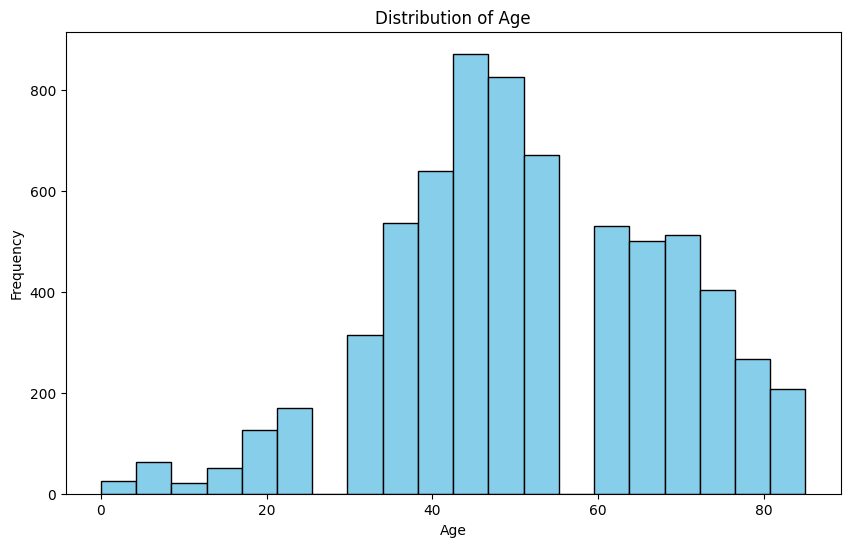

In [47]:
plt.figure(figsize=(10, 6))
plt.hist(skin_df['age'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of Age')
plt.show()

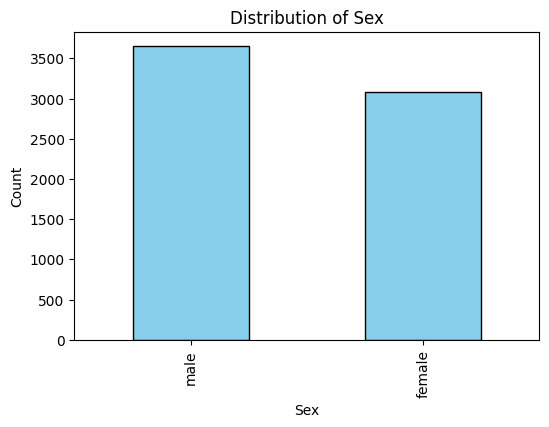

In [48]:
plt.figure(figsize=(6, 4))
skin_df['sex'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.title('Distribution of Sex')
plt.show()

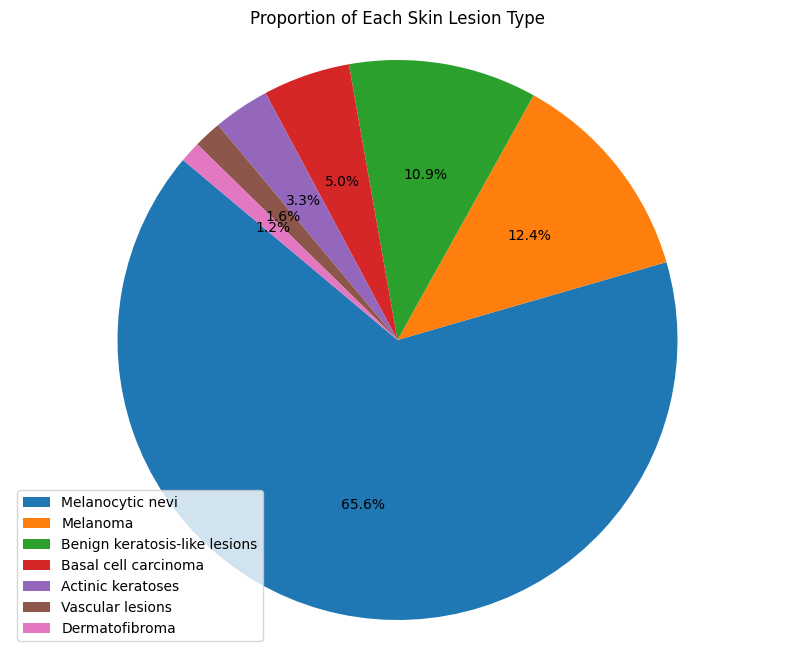

In [49]:
# Dictionary to map lesion type codes to their full names
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

# Get the counts of each lesion type
lesion_type_counts = skin_df['dx'].value_counts()

# Create labels and sizes for the pie chart
labels = [lesion_type_dict[code] for code in lesion_type_counts.index]
sizes = lesion_type_counts.values

# Create the pie chart with percentage labels
plt.figure(figsize=(10, 8))
plt.pie(sizes, labels=None, startangle=140, autopct='%1.1f%%')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Proportion of Each Skin Lesion Type')

# Add a legend based on color
plt.legend(labels, loc="best")
plt.show()

In [50]:
# Class-balancing
SAMPLE_PER_GROUP = 1500
skin_train_df = skin_train_df.groupby('dx', as_index=False).apply(lambda x: x.sample(SAMPLE_PER_GROUP//2, replace=True)).reset_index(drop=True)
print(skin_train_df.shape[0])
print(skin_train_df['dx'].value_counts())

5250
dx
akiec    750
bcc      750
bkl      750
df       750
mel      750
nv       750
vasc     750
Name: count, dtype: int64


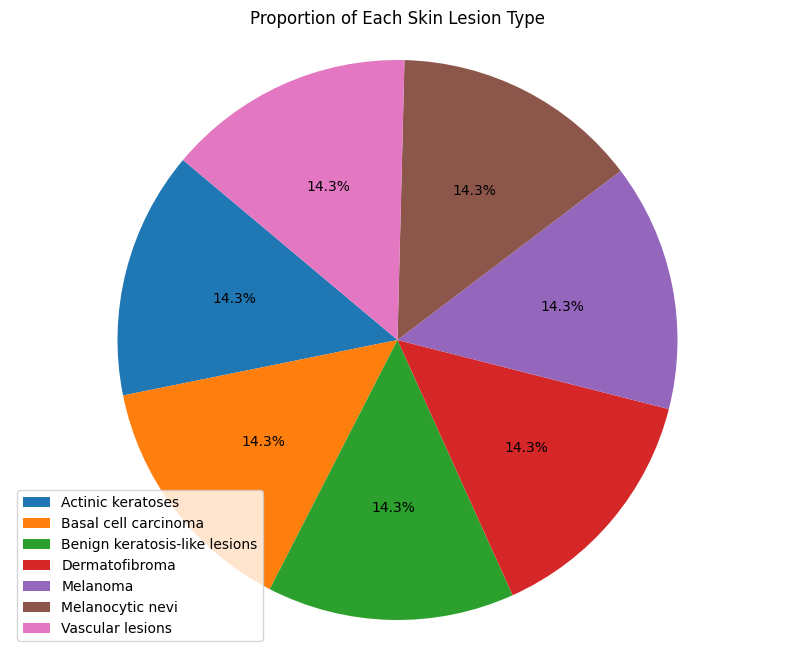

In [51]:
# Get the counts of each lesion type
lesion_type_counts = skin_train_df['dx'].value_counts()

# Create labels and sizes for the pie chart
labels = [lesion_type_dict[code] for code in lesion_type_counts.index]
sizes = lesion_type_counts.values

# Create the pie chart with percentage labels
plt.figure(figsize=(10, 8))
plt.pie(sizes, labels=None, startangle=140, autopct='%1.1f%%')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Proportion of Each Skin Lesion Type')

# Add a legend based on color
plt.legend(labels, loc="best")
plt.show()

In [52]:
 # Drop columns except for image_id and dx
skin_train_df = skin_train_df.drop(['lesion_id', 'dx_type', 'age', 'sex', 'localization'], axis=1)
skin_train_df = skin_train_df.reset_index(drop=True)

skin_train_df.head(5)

,image_id,dx
0,ISIC_0033866,akiec
1,ISIC_0026203,akiec
2,ISIC_0029638,akiec
3,ISIC_0029541,akiec
4,ISIC_0033358,akiec


In [53]:
print('Shape of train_df : ', skin_train_df.shape, '\n')

Shape of train_df :  (5250, 2) 



# Creating Custom Dataset

In [54]:
class HAM10000(Dataset):
    def __init__(self, df, root, train_mode=True):

        self.data = []
        self.targets = []
        self.df = df
        self.root = root
        self.train_mode = train_mode

        # Transform the images
        self.transform = transforms.Compose([
            transforms.Resize(384),
            transforms.RandomRotation(20),  # Random rotation between -20 to 20 degrees
            transforms.RandomHorizontalFlip(),  # Random horizontal flip
            transforms.RandomVerticalFlip(),  # Random vertical flip
            transforms.ToTensor(),  # Convert to PyTorch Tensor
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
        ])

        # append filepath to data and integer labels to targets
        for idx in range(len(self.df)):
            filename = self.df['image_id'].iloc[idx]
            filepath = os.path.join(root, filename + '.jpg')
            self.data.append(filepath)
            target = self.label_to_int(self.df['dx'].iloc[idx])
            self.targets.append(target)

    def __len__(self):
        return len(self.df)

    # get integer that represent a class
    def label_to_int(self, label):
        label_dict = {
            'nv': 0,      # Melanocytic nevi
            'mel': 1,     # Melanoma
            'bkl': 2,     # Benign keratosis-like lesions
            'bcc': 3,     # Basal cell carcinoma
            'akiec': 4,   # Actinic keratoses
            'vasc': 5,    # Vascular lesions
            'df': 6       # Dermatofibroma
        }

        return label_dict.get(label, -1)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        image = Image.open(img_path)
        image = self.transform(image)
        label = self.targets[idx]

        return image, label

    def split_train_test(self, train_ratio=0.9):
        train_size = int(train_ratio * len(self))
        test_size = len(self) - train_size
        train_set, test_set = torch.utils.data.random_split(self, [train_size, test_size])

        return train_set, test_set

In [55]:
# Create dataset for training, validation and testing
trainset = HAM10000(skin_train_df, "Dataset/HAM10000/", train_mode=True)
trainset, testset = trainset.split_train_test(train_ratio=0.8)

In [56]:
# Show the elements in each dataset
print(f"Train set contains : {len(trainset)}\n")
print(f"Test set contains : {len(testset)}\n")

Train set contains : 4200

Test set contains : 1050



In [57]:
# Create DataLoaders sand use the sampler to sampling the data
trainloader = DataLoader(trainset, batch_size=8, shuffle=True)
testloader = DataLoader(testset, batch_size=8, shuffle=True)


# Create ResNet50 model
ResNet-50 is a deep convolutional neural network architecture that is 50 layers deep. It is a variant of the ResNet model (Residual Network) introduced by Microsoft Research. ResNet-50 is renowned for its performance in image classification tasks, particularly in large-scale datasets like ImageNet. The key innovation in ResNet-50 is the use of residual blocks, which contain skip connections (or shortcuts) that allow the model to learn residual functions. These shortcuts help in addressing the vanishing gradient problem, enabling the training of very deep networks effectively. ResNet-50 is composed of several blocks, including convolutional layers, batch normalization, ReLU activation functions, and max-pooling layers, culminating in a global average pooling layer and a softmax output layer for classification.

In [64]:
# Load pretrained ResNet50 model
model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
model

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 165MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [65]:
# Modify the classifier layer to match with our case
model.fc = nn.Linear(in_features = 2048, out_features = 7)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

#Model Training and Evaluation

In [66]:
def train(model, dataloader, device, num_epochs, lr=0.1, momentum=0.8, step_size=5, gamma=0.5, verbose=True):

    history = []
    loss_iterations = int(np.ceil(len(dataloader)/3))

    model = model.to(device)

    # set the optimizer
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    # set the scheduler
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    model.train()

    for e in range(num_epochs):

        running_loss = 0.0
        running_count = 0.0

        for i, (inputs, labels) in enumerate(dataloader):

            optimizer.zero_grad()

            if torch.cuda.is_available():
                inputs = inputs.to(device)
                labels = labels.to(device)

            labels = labels.reshape(-1, 1).float()

            outs = model(inputs)
            loss = nn.CrossEntropyLoss()(outs, labels.squeeze().long())
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            running_count += 1

            if (i + 1) % loss_iterations == 0 or i == len(dataloader) - 1:
                train_loss = running_loss / running_count
                running_loss = 0.
                running_count = 0.
                if verbose:
                    print(f'[Epoch {e+1:2d}/{num_epochs:d} Iter {i+1:5d}/{len(dataloader)}]: train_loss = {train_loss:.4f}')

                history.append(train_loss)

        # Free memory after each epoch
        del inputs, labels, outs, loss  # Delete intermediate variables

        if torch.cuda.is_available():
            torch.cuda.empty_cache()  # Empty PyTorch cache on GPU

        # update scheduler
        scheduler.step()

    return history

In [67]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
history = train(model, trainloader, device, num_epochs=15, lr=0.01, step_size=5, gamma=0.1)

[Epoch  1/15 Iter   175/525]: train_loss = 1.4790
[Epoch  1/15 Iter   350/525]: train_loss = 1.0353
[Epoch  1/15 Iter   525/525]: train_loss = 0.8735
[Epoch  2/15 Iter   175/525]: train_loss = 0.7041
[Epoch  2/15 Iter   350/525]: train_loss = 0.6660
[Epoch  2/15 Iter   525/525]: train_loss = 0.6189
[Epoch  3/15 Iter   175/525]: train_loss = 0.4870
[Epoch  3/15 Iter   350/525]: train_loss = 0.5397
[Epoch  3/15 Iter   525/525]: train_loss = 0.4704
[Epoch  4/15 Iter   175/525]: train_loss = 0.4004
[Epoch  4/15 Iter   350/525]: train_loss = 0.4274
[Epoch  4/15 Iter   525/525]: train_loss = 0.4504
[Epoch  5/15 Iter   175/525]: train_loss = 0.3325
[Epoch  5/15 Iter   350/525]: train_loss = 0.3880
[Epoch  5/15 Iter   525/525]: train_loss = 0.3364
[Epoch  6/15 Iter   175/525]: train_loss = 0.2496
[Epoch  6/15 Iter   350/525]: train_loss = 0.1894
[Epoch  6/15 Iter   525/525]: train_loss = 0.1959
[Epoch  7/15 Iter   175/525]: train_loss = 0.1815
[Epoch  7/15 Iter   350/525]: train_loss = 0.1551


In [68]:
def evaluate(net, dataloader, device):
    # set to evaluation mode
    net.eval()

    # running_correct
    running_corrects = 0
    all_targets = []
    all_predicted = []

    for inputs, targets in dataloader:

        # transfer to the GPU
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            targets = targets.cuda()

        # perform prediction (no need to compute gradient)
        with torch.no_grad():
            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)  # Get the index of the max log-probability
            running_corrects += (targets == predicted).sum().item()

            all_targets.extend(targets.cpu().numpy())
            all_predicted.extend(predicted.cpu().numpy())

    acc = running_corrects / len(dataloader.dataset)

    print(f'Accuracy: {acc:.2f}')

    # Calculate confusion matrix
    cm = confusion_matrix(all_targets, all_predicted)

    # Display confusion matrix as a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[str(i) for i in range(7)], yticklabels=[str(i) for i in range(7)])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    # Compute and display classification report
    report = classification_report(all_targets, all_predicted, target_names=[str(i) for i in range(7)])
    print("Classification Report:")
    print(report)

Accuracy: 0.93


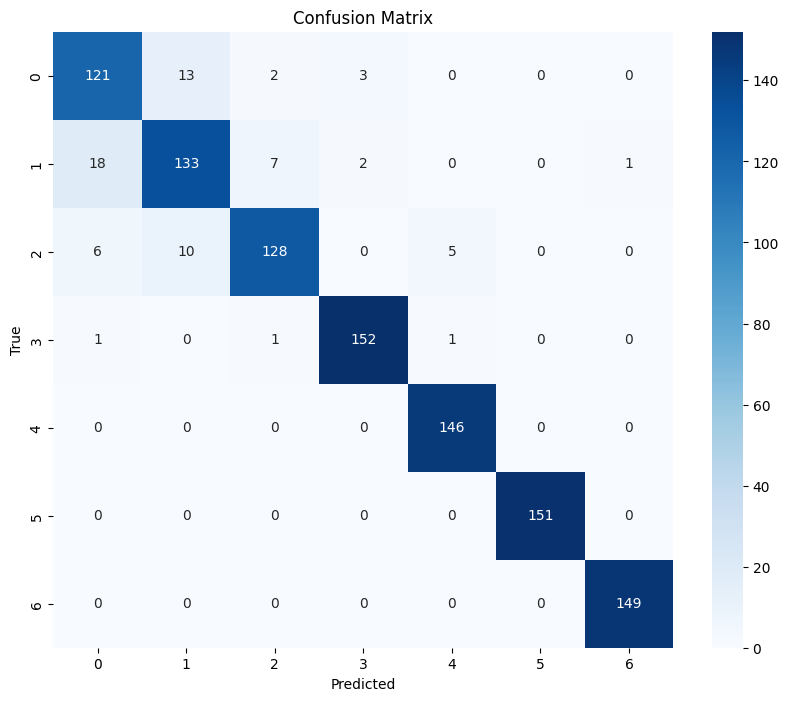

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       139
           1       0.85      0.83      0.84       161
           2       0.93      0.86      0.89       149
           3       0.97      0.98      0.97       155
           4       0.96      1.00      0.98       146
           5       1.00      1.00      1.00       151
           6       0.99      1.00      1.00       149

    accuracy                           0.93      1050
   macro avg       0.93      0.93      0.93      1050
weighted avg       0.93      0.93      0.93      1050



In [69]:
evaluate(model, testloader, device)

In [72]:
# Define the file path where you want to save the model
save_path = "/content/drive/MyDrive/UCCD3074_Labs/Assignment2/model.pth"
torch.save(model.state_dict(), save_path)

In [ ]:
# Load the trained model
model.load_state_dict(torch.load(save_path))